# Libraries

In [1]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

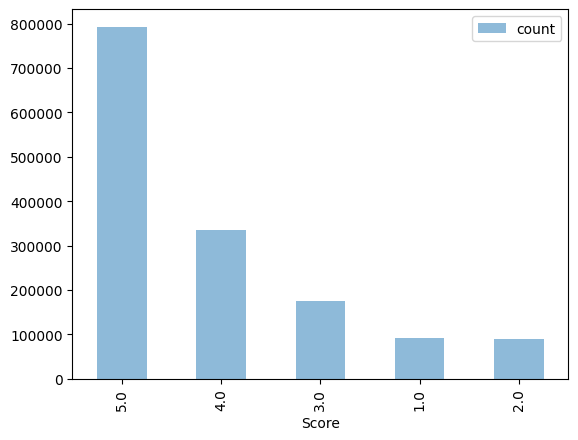


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [2]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [5]:
from textblob import TextBlob
from sklearn.utils import shuffle

def add_features_to(df):
    # This is where you can do all your feature extraction

    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)
    
    # Add the length of the review
    df['ReviewLength'] = df['Text'].apply(lambda x: len(x) if pd.notnull(x) else 0)
    
    # Add the word count
    df['WordCount'] = df['Text'].apply(lambda x: len(x.split()) if pd.notnull(x) else 0)
    
    # Perform sentiment analysis on the information
    df['ReviewSentiment'] = df['Text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    
    # Add if there's a summary
    df['HasSummary'] = df['Summary'].apply(lambda x: 1 if pd.notnull(x) and len(x) > 0 else 0)
    
    # Fill missing values for any possible NaNs
    df.fillna({
        'HelpfulnessNumerator': 0, 
        'HelpfulnessDenominator': 1, 
        'Text': '', 
        'Summary': ''
    }, inplace = True)
    
    return df

# Randomly sample a subset of the training set -- 10% of the data
sample_fraction = 0.1
trainingSet_sampled = shuffle(trainingSet).sample(frac=sample_fraction, random_state=42)

# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")

else:
    # Process the DataFrame
    train = add_features_to(trainingSet_sampled)

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train =  train[train['Score'].notnull()]

    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

# Sample + Split into training and testing set

In [8]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0,
    stratify = X_train['Score'] # Balanced Distribution
)

# Feature Selection

In [10]:
from sklearn.preprocessing import StandardScaler
features = [
    'HelpfulnessNumerator', 
    'HelpfulnessDenominator', 
    'Time', 
    'Helpfulness', 
    'ReviewLength', 
    'WordCount'
    ]

X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

# Apply Standard Scaling
scaler = StandardScaler()

X_train_select = scaler.fit_transform(X_train_select)
X_test_select = scaler.transform(X_test_select)
X_submission_select = scaler.transform(X_submission_select)

# Model Creation

In [11]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid_search.fit(X_train_select, Y_train)

best_model = grid_search.best_estimator_
model = best_model.fit(X_train_select, Y_train)
Y_test_predictions = model.predict(X_test_select)
print("Best parameters:", grid_search.best_params_)


# # Learn the model
# model = KNeighborsClassifier(n_neighbors=3).fit(X_train_select, Y_train)

# # Predict the score using the model
# Y_test_predictions = model.predict(X_test_select)

Best parameters: {'n_neighbors': 11}


# Model Evaluation

Accuracy on testing set =  0.5128508951461749


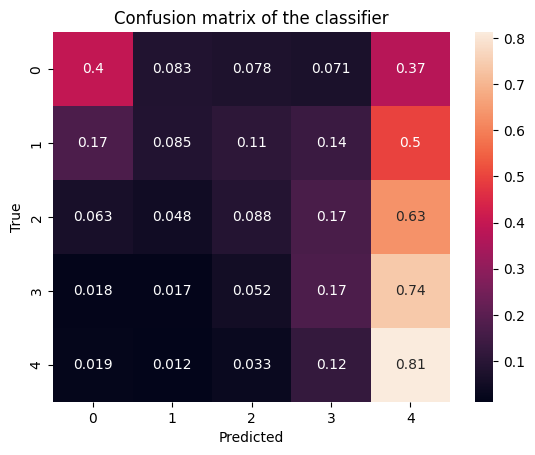

In [12]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [13]:
# Create the submission file
X_submission['Score'] = model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)

             Id  Score
0       1323432    5.0
1       1137299    5.0
2       1459366    5.0
3        931601    5.0
4       1311995    5.0
...         ...    ...
212187   510697    5.0
212188   230001    5.0
212189  1346402    5.0
212190   695280    5.0
212191  1371294    5.0

[212192 rows x 2 columns]


AttributeError: 'NoneType' object has no attribute 'shape'